In [16]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [17]:
# %cd /gdrive/My drive/Colab Notebooks/ExercisesANN/Homework1

In [18]:
pip install split-folders tqdm

In [19]:
import tensorflow as tf
import numpy as np
import shutil
import os
import random
import pandas as pd
import splitfolders as split
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [20]:
%config Completer.use_jedi = False
print('ok')

ok


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [21]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#other useful parameters
batchSize = 8
input_shape = (256, 256, 3)
epochs = 100

In [22]:
# Load the dataset to be used for classification
!unzip '/gdrive/MyDrive/Colab Notebooks/ExercisesANN/Homework1/dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: training/Tomato/37979.jpg  
  inflating: training/Tomato/37980.jpg  
  inflating: training/Tomato/37982.jpg  
  inflating: training/Tomato/37983.jpg  
  inflating: training/Tomato/37984.jpg  
  inflating: training/Tomato/37985.jpg  
  inflating: training/Tomato/37988.jpg  
  inflating: training/Tomato/37989.jpg  
  inflating: training/Tomato/37990.jpg  
  inflating: training/Tomato/37992.jpg  
  inflating: training/Tomato/37993.jpg  
  inflating: training/Tomato/37994.jpg  
  inflating: training/Tomato/37995.jpg  
  inflating: training/Tomato/37996.jpg  
  inflating: training/Tomato/37997.jpg  
  inflating: training/Tomato/37998.jpg  
  inflating: training/Tomato/37999.jpg  
  inflating: training/Tomato/38000.jpg  
  inflating: training/Tomato/38001.jpg  
  inflating: training/Tomato/38003.jpg  
  inflating: training/Tomato/38004.jpg  
  inflating: training/Tomato/38005.jpg  
  inflating: training/Tomato/38006.jpg  
  infl

In [23]:
# Dataset folders 
dataset_dir = '/content'
dataset_in = '/content/training'
dataset_out = '/content/output'
training_dir = os.path.join(dataset_out, 'train')
validation_dir = os.path.join(dataset_out, 'val')

In [24]:
# Splitting dataset in training and validation 
split.ratio(dataset_in, output=dataset_out, seed=seed, ratio=(.9,.1), group_prefix=None)

Copying files: 17728 files [00:03, 5767.06 files/s]


In [25]:

#from google.colab import files
#import os

#dir_to_zip = '/content/output'#metti nome del file su colab 
#output_filename = 'fileDataset.zip'#(nome di come vuoi salvarlo 
#delete_dir_after_download = "No" 

#os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

#if delete_dir_after_download == "Yes":
#   os.system( "rm -r {}".format( dir_to_zip ) )

#files.download( output_filename )


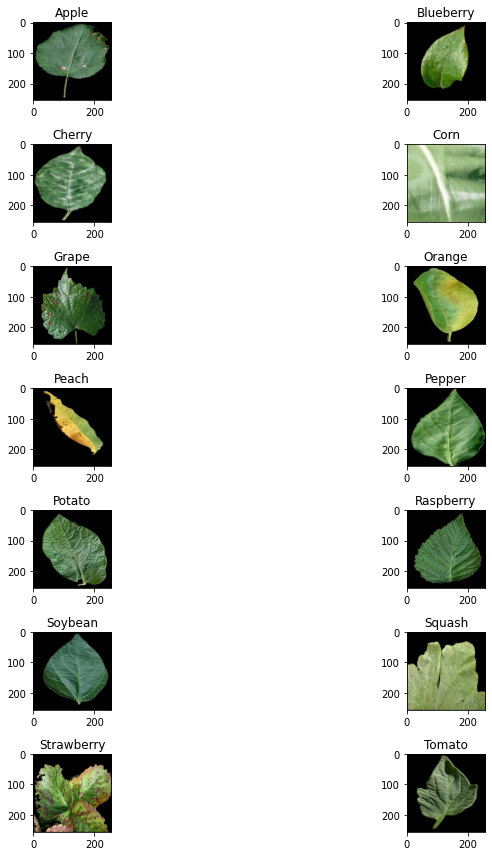

In [26]:
# Plot example images from dataset
labels = [
    'Apple',        #0
    'Blueberry',    #1
    'Cherry',       #2
    'Corn',         #3
    'Grape',        #4
    'Orange',       #5
    'Peach',        #6
    'Pepper',       #7
    'Potato',       #8
    'Raspberry',    #9
    'Soybean',      #10
    'Squash',       #11
    'Strawberry',   #12
    'Tomato',       #13
]

num_row = 7
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))
for i in range(num_row*num_col):
  if i < 14:
    class_imgs = next(os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [27]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training and validation sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256,256),
                                               interpolation='lanczos',
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batchSize,
                                               shuffle=True,
                                               seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               interpolation='lanczos',
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batchSize,
                                               shuffle=False,
                                               seed=seed)

Found 15949 images belonging to 14 classes.
Found 1779 images belonging to 14 classes.


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.4),
        layers.RandomTranslation(height_factor=0.4, width_factor=0.4),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.3),
        #layers.RandomCrop(height=0.3, width=0.3),
        #layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="img_augmentation",
)

In [29]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b7.tar.gz


--2021-11-22 19:54:08--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b7.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.81.208, 142.250.188.48, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.81.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491946092 (469M) [application/octet-stream]
Saving to: ‘noisy_student_efficientnet-b7.tar.gz’

noisy_student_effic 100%[===================>] 469.16M   101MB/s    in 5.6s    

2021-11-22 19:54:14 (84.3 MB/s) - ‘noisy_student_efficientnet-b7.tar.gz’ saved [491946092/491946092]



In [30]:
!tar -xf noisy_student_efficientnet-b7.tar.gz

In [31]:
!python '/gdrive/MyDrive/Colab Notebooks/ExercisesANN/Homework1/efficientnet_weight_update_util.py' --model b7 --notop --ckpt /content/noisy_student_efficientnet-b7/model.ckpt --o efficientnetb1_notop.h5

2021-11-22 19:54:25.583922: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
258088960/258076736 [==============================] - 2s 0us/step
check variables match in each block
blocks_0 and block1a match.
blocks_1 and block1b match.
blocks_2 and block1c match.
blocks_3 and block1d match.
blocks_4 and block2a match.
blocks_5 and block2b match.
blocks_6 and block2c match.
blocks_7 and block2d match.
blocks_8 and block2e match.
blocks_9 and block2f match.
blocks_10 and block2g match.
blocks_11 and block3a match.
blocks_12 and block3b match.
blocks_13 and block3c match.
blocks_14 and block3d match.
blocks_15 and block3e match.
blocks_16 and block3f match.
blocks_17 and block3g match.
blocks_18 and block4a match.
blocks_19 and block4b match.
blocks_20 and block4c match.
blocks_21 and block4d match.
blocks_22 and block4e match.
blocks_23 and block4f match.
blocks_24 and block4g match.
blocks_25 and block4

In [32]:
from tensorflow.keras.applications import * #Efficient Net included here
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import pandas as pd
from sklearn import model_selection
from tqdm import tqdm
from tensorflow.keras import optimizers
import tensorflow as tf

def build_efficientNetB7(input_shape):

    inputs = layers.Input(shape=input_shape)
    x = img_augmentation(inputs)
    model = EfficientNetB7(include_top=False, input_tensor=x, weights="efficientnetb7_notop.h5")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(14, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model



In [33]:
def unfreeze_model(model):
    # We unfreeze the top 30 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-30:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )



In [34]:
model = build_efficientNetB7(input_shape)
unfreeze_model(model)

model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['img_augmentation[0][0]']       
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']   

In [35]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [36]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

In [37]:
# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100


KeyboardInterrupt: ignored